In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to dynamically get severity levels for stakeholders
def get_severity_levels(stakeholders):
    severity_levels = {}
    print("Please assign severity levels (1-8) for the following stakeholders:")

    for stakeholder in stakeholders:
        while True:
            try:
                severity = int(input(f'Severity for {stakeholder}: '))
                if severity < 1 or severity > 8:
                    raise ValueError
                severity_levels[stakeholder] = severity
                break
            except ValueError:
                print("Invalid input. Please enter a severity level between 1 and 8.")

    return severity_levels

In [5]:
# Load the detailed CSV
df = pd.read_csv(r'C:\Users\Sofia\PycharmProjects\aiaaic-harms-severity\results\categories_stakeholders_detailed.csv')

In [6]:
# Print all unique stakeholder names
unique_stakeholders = df['stakeholders'].unique()
print("Unique stakeholders in the dataset:")
for stakeholder in unique_stakeholders:
    print(stakeholder)

Unique stakeholders in the dataset:
Artists/content creators
General public
Government/public sector
Users
Vulnerable groups
Workers
Business
Investors
Subjects
Government/public service


In [11]:
# Get the severity levels dynamically for all unique stakeholders
severity_levels = get_severity_levels(unique_stakeholders)

# Map severity levels
df['severity'] = df['stakeholders'].map(severity_levels)

# Handle cases where severity is not available
df['severity'].fillna(1, inplace=True)  # Default severity to 1 if not provided

Please assign severity levels (1-8) for the following stakeholders:


In [12]:
# Initialize a list to collect all cumulative proportions
all_cumulative_proportions = []

In [13]:
def calculate_gini_for_category(df, category):
    # Filter by category
    df_category = df[df['harm_category'] == category].copy()  # Use copy() to avoid modifying the original DataFrame

    # Sort by severity
    df_category = df_category.sort_values(by='severity')

    # Calculate cumulative frequency and severity
    df_category['cum_freq'] = df_category['freq'].cumsum()
    df_category['cum_severity'] = df_category['severity'].cumsum()

    # Normalize cumulative frequency and cumulative severity
    df_category['cum_freq_norm'] = df_category['cum_freq'] / df_category['freq'].sum()
    df_category['cum_severity_norm'] = df_category['cum_severity'] / df_category['severity'].sum()

    # Lorenz curve: cumulative share of severity vs cumulative share of frequency
    lorenz_curve = df_category['cum_freq_norm'].values

    # Add the point (0,0) to the Lorenz curve
    lorenz_curve = np.insert(lorenz_curve, 0, 0)

    # Calculate the Gini index using the trapezoidal rule
    area_under_lorenz = np.trapz(lorenz_curve, dx=1 / len(lorenz_curve))
    gini_index = 1 - 2 * area_under_lorenz

    # Plot the Lorenz curve
    plt.plot(np.linspace(0, 1, len(lorenz_curve)), lorenz_curve, label=f'{category} (Gini: {gini_index:.2f})')
    plt.fill_between(np.linspace(0, 1, len(lorenz_curve)), lorenz_curve, alpha=0.2)

    # Calculate the cumulative proportion
    total_freq = df_category['freq'].sum()
    df_category['cumulative_proportion'] = df_category['cum_freq'] / total_freq

    # Add category column to the DataFrame for tracking (only if it doesn't already exist)
    if 'category' not in df_category.columns:
        df_category.insert(0, 'category', category)

    # Append the results to the list
    all_cumulative_proportions.append(df_category)

    # Print the category and the cumulative proportions
    print(f'\nCategory: {category}')
    print(df_category[['category', 'stakeholders', 'freq', 'cum_freq', 'cumulative_proportion']])

    return gini_index


Category: Autonomy
   category              stakeholders  freq  cum_freq  cumulative_proportion
0  Autonomy  Artists/content creators    15        15               0.220588
1  Autonomy            General public     6        21               0.308824
2  Autonomy  Government/public sector     3        24               0.352941
3  Autonomy                     Users    29        53               0.779412
4  Autonomy         Vulnerable groups    10        63               0.926471
5  Autonomy                   Workers     5        68               1.000000

Category: Emotional & psychological
                     category              stakeholders  freq  cum_freq  \
6   Emotional & psychological  Artists/content creators     1         1   
7   Emotional & psychological            General public     8         9   
8   Emotional & psychological  Government/public sector     5        14   
9   Emotional & psychological                     Users    19        33   
10  Emotional & psychological

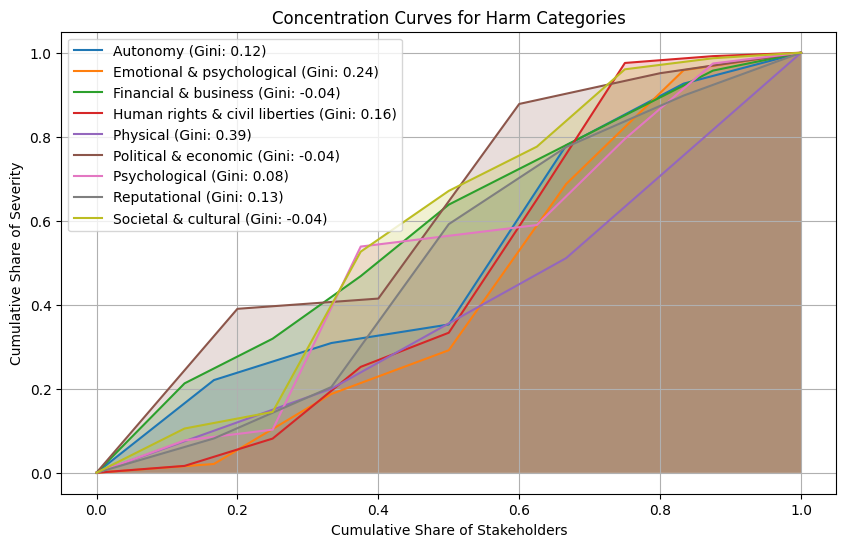

                    harm_category  gini_index
0                        Autonomy    0.117647
1       Emotional & psychological    0.244048
2            Financial & business   -0.042553
3  Human rights & civil liberties    0.155375
4                        Physical    0.394444
5            Political & economic   -0.044715
6                   Psychological    0.079772
7                    Reputational    0.128280
8             Societal & cultural   -0.038012


In [14]:
# Calculate and plot the Gini index for each harm category
categories = df['harm_category'].unique()
plt.figure(figsize=(10, 6))

gini_indices = {}
for category in categories:
    gini_index = calculate_gini_for_category(df, category)
    gini_indices[category] = gini_index

plt.title('Concentration Curves for Harm Categories')
plt.xlabel('Cumulative Share of Stakeholders')
plt.ylabel('Cumulative Share of Severity')
plt.legend()
plt.grid(True)
plt.show()

# Concatenate all cumulative proportions into a single DataFrame
all_cumulative_df = pd.concat(all_cumulative_proportions)

# Remove the 'category' column before saving to CSV since it's redundant
all_cumulative_df = all_cumulative_df.drop(columns=['category'])

# Save the cumulative proportions into a single CSV
all_cumulative_df.to_csv('results/all_cumulative_proportions.csv', index=False)

# Save the Gini indices as a CSV
gini_df = pd.DataFrame(list(gini_indices.items()), columns=['harm_category', 'gini_index'])
gini_df.to_csv('results/gini_indices.csv', index=False)

print(gini_df)